In [ ]:
#!pip install missingno

In [ ]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import missingno as msno
from scipy.stats import chi2_contingency
from tqdm import tqdm
import scipy.stats as st
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, log_loss
from itertools import product
from collections import Counter
from sklearn.base import clone
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.utils import check_X_y, check_array
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict
import shap

## Q84

In [ ]:
full_df = pd.read_csv('OutputData/mental_health_full.csv')

df_84 = full_df[full_df['q84_binary'].isin([0, 1])].copy()
df_84['target'] = df_84['q84_binary']

# Step 2: Drop irrelevant columns
X84 = df_84.drop(columns=['q26', 'q27', 'q84', 'q84_binary', 'target', 'state', 'sitename', 'q28'])
y84 = df_84['target']

X84 = X84.select_dtypes(include=[float, int]).dropna()
y84 = y84.loc[X84.index]

# print('types of features in X')
print('x.shape ', X84.shape)
print('y.shape ', y84.shape)

X84_train, X84_test, y84_train, y84_test = train_test_split(
    X84, y84, test_size=0.3, random_state=42, stratify=y84
)

numeric_columns = ['bmipct', 'gdp 2023', 'Unemployment Rate(Percent)', 'Mean household income (dollars)']

# Step 4: Scale features
scaler = StandardScaler()
X84_train[numeric_columns] = scaler.fit_transform(X84_train[numeric_columns])
X84_test[numeric_columns] = scaler.transform(X84_test[numeric_columns])


x.shape  (1604, 13)
y.shape  (1604,)


## Sparse Logistic Regression

/tmp/ipython-input-61-2890422520.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Coefficient', y='Label', data=top_features_slr, palette='coolwarm')


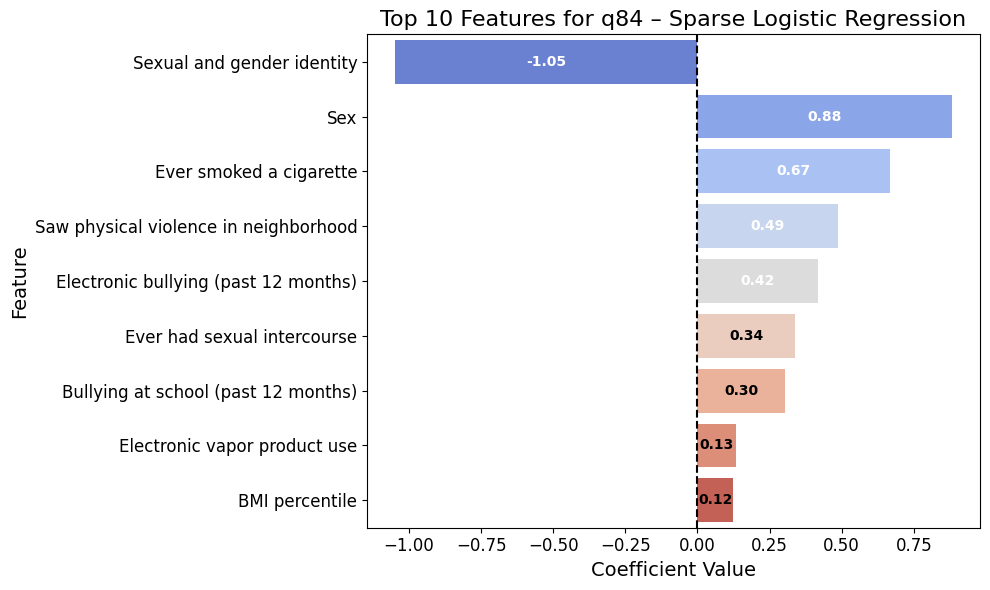

Cross-Validation (20-fold):
Accuracy: 0.7655 ± 0.0063
Log Loss: 0.5131 ± 0.0105

Test Set Performance:
Accuracy: 0.7241
Log Loss: 0.5577

Confusion Matrix:
                        Predicted 0  Predicted 1
Actual 0 (No Sadness)           312           39
Actual 1 (Yes Sadness)           94           37

False Positive Rate (FPR): 0.1111
False Negative Rate (FNR): 0.7176


In [ ]:
# Step 6: Train final model on train set (used for interpretation only!)
model_slr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
model_slr.fit(X84_train, y84_train)

# Store feature names and coefficients before any overwriting
final_coef_slr = model_slr.coef_[0]
final_features_slr = X84.columns

# Step 12: Top 10 features (based on model trained before CV)
coef_df_slr = pd.DataFrame({
    'Feature': final_features_slr,
    'Coefficient': final_coef_slr
})
non_zero_slr = coef_df_slr[coef_df_slr['Coefficient'] != 0]
top_features_slr = non_zero_slr.sort_values(by='Coefficient', key=abs, ascending=False).head(10)
top_features_slr['Label'] = top_features_slr['Feature'].map(feature_labels).fillna(top_features_slr['Feature'])

# Step 13: Plot top features
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Coefficient', y='Label', data=top_features_slr, palette='coolwarm')
for i, (value, name) in enumerate(zip(top_features_slr['Coefficient'], top_features_slr['Label'])):
    ax.text(value / 2, i, f"{value:.2f}",
            color='white' if abs(value) > 0.4 else 'black',
            ha='center', va='center', fontweight='bold')

plt.title('Top 10 Features for q84 – Sparse Logistic Regression', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


# ------------------ Evaluation Metrics ------------------ #

# --- 1. Cross-Validation Accuracy and Log Loss with CI --- #
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

cv_accuracy_scores = cross_val_score(model_slr, X84_train, y84_train, cv=cv, scoring='accuracy')
cv_logloss_scores = cross_val_score(model_slr, X84_train, y84_train, cv=cv, scoring='neg_log_loss')

# Convert log loss scores to positive
cv_logloss_scores = -cv_logloss_scores

# 95% Confidence Intervals
acc_ci = st.t.interval(0.95, len(cv_accuracy_scores)-1, loc=np.mean(cv_accuracy_scores), scale=st.sem(cv_accuracy_scores))
logloss_ci = st.t.interval(0.95, len(cv_logloss_scores)-1, loc=np.mean(cv_logloss_scores), scale=st.sem(cv_logloss_scores))

print("Cross-Validation (20-fold):")
print(f"Accuracy: {np.mean(cv_accuracy_scores):.4f} ± {st.sem(cv_accuracy_scores):.4f}")
print(f"Log Loss: {np.mean(cv_logloss_scores):.4f} ± {st.sem(cv_logloss_scores):.4f}")

# --- 2. Test Accuracy and Log Loss --- #
y84_pred = model_slr.predict(X84_test)
y84_proba = model_slr.predict_proba(X84_test)[:, 1]

test_accuracy = accuracy_score(y84_test, y84_pred)
test_logloss = log_loss(y84_test, y84_proba)

print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Log Loss: {test_logloss:.4f}")

# --- 3. Confusion Matrix + FPR, FNR --- #
# Compute confusion matrix
conf_matrix = confusion_matrix(y84_test, y84_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Compute FPR and FNR
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Format into DataFrame
conf_df = pd.DataFrame(
    conf_matrix,
    index=["Actual 0 (No Sadness)", "Actual 1 (Yes Sadness)"],
    columns=["Predicted 0", "Predicted 1"]
)

# Print results
print("\nConfusion Matrix:")
print(conf_df)
print(f"\nFalse Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")



## Random Forest

Fitting 5 folds for each of 20 candidates, totalling 100 fits

 Random Forest with RandomizedSearchCV
Best Parameters: {'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 6}


/tmp/ipython-input-62-912631328.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Label', data=top10_rf, palette='YlGnBu_r')
/tmp/ipython-input-62-912631328.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Label', data=top10_rf, palette='viridis')


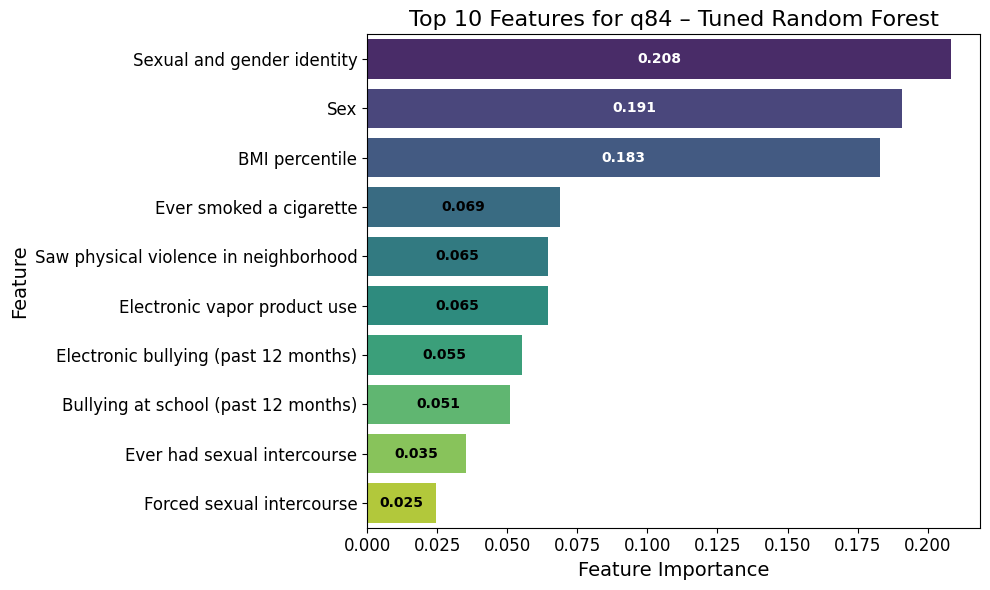


Cross-Validation (20-fold):
Accuracy: 0.6997 ± 0.0505
Log Loss: 0.5906 ± 0.0352

Test Set Performance:
Accuracy: 0.6390
Log Loss: 0.6378

Confusion Matrix:
                        Predicted 0  Predicted 1
Actual 0 (No Sadness)           236          115
Actual 1 (Yes Sadness)           59           72

False Positive Rate (FPR): 0.3276
False Negative Rate (FNR): 0.4504


In [ ]:
# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': range(5, 25),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(2, 11),
    'max_features': ['sqrt', 'log2']
}

# Initialize base model
base_rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Randomized search (20 iterations, 5-fold CV)
rf_search = RandomizedSearchCV(
    base_rf,
    param_distributions=param_grid_rf,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit search on training data
rf_search.fit(X84_train, y84_train)

# Best estimator
best_rf = rf_search.best_estimator_

# Predict on test set
y_pred_rf = best_rf.predict(X84_test)
y_prob_rf = best_rf.predict_proba(X84_test)[:, 1]

print("\n Random Forest with RandomizedSearchCV")
print("Best Parameters:", rf_search.best_params_)

# Top 10 important features
importances_rf = best_rf.feature_importances_
rf_importance_df = pd.DataFrame({
    'Feature': X84.columns,
    'Importance': importances_rf
})
top10_rf = rf_importance_df.sort_values(by='Importance', ascending=False).head(10)
top10_rf['Label'] = top10_rf['Feature'].map(feature_labels).fillna(top10_rf['Feature'])

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Label', data=top10_rf, palette='YlGnBu_r')

for i, (imp, label) in enumerate(zip(top10_rf['Importance'], top10_rf['Label'])):
    ax.text(imp / 2, i, f"{imp:.3f}",
            ha='center', va='center',
            fontsize=10, fontweight='bold',
            color='white' if imp > 0.08 else 'black')
sns.barplot(x='Importance', y='Label', data=top10_rf, palette='viridis')
plt.title("Top 10 Features for q84 – Tuned Random Forest", fontsize=16)
plt.xlabel("Feature Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# -------------------- Cross-Validation Performance (20-fold) -------------------- #
cv_accuracy_rf = cross_val_score(best_rf, X84_train, y84_train, cv=20, scoring='accuracy')
cv_logloss_rf = -cross_val_score(best_rf, X84_train, y84_train, cv=20, scoring='neg_log_loss')

print("\nCross-Validation (20-fold):")
print(f"Accuracy: {cv_accuracy_rf.mean():.4f} ± {cv_accuracy_rf.std():.4f}")
print(f"Log Loss: {cv_logloss_rf.mean():.4f} ± {cv_logloss_rf.std():.4f}")

# -------------------- Test Set Performance -------------------- #
test_accuracy_rf = accuracy_score(y84_test, y_pred_rf)
test_logloss_rf = log_loss(y84_test, y_prob_rf)

print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy_rf:.4f}")
print(f"Log Loss: {test_logloss_rf:.4f}")

# -------------------- Confusion Matrix + FPR, FNR -------------------- #
conf_matrix_rf = confusion_matrix(y84_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = conf_matrix_rf.ravel()

fpr_rf = fp_rf / (fp_rf + tn_rf)
fnr_rf = fn_rf / (fn_rf + tp_rf)

conf_df_rf = pd.DataFrame(
    conf_matrix_rf,
    index=["Actual 0 (No Sadness)", "Actual 1 (Yes Sadness)"],
    columns=["Predicted 0", "Predicted 1"]
)

print("\nConfusion Matrix:")
print(conf_df_rf)
print(f"\nFalse Positive Rate (FPR): {fpr_rf:.4f}")
print(f"False Negative Rate (FNR): {fnr_rf:.4f}")


## Model Comparsion

Shared Top Features (SLR & RF):
→ BMI percentile
→ Saw physical violence in neighborhood
→ Bullying at school (past 12 months)
→ Electronic bullying (past 12 months)
→ Ever smoked a cigarette
→ Electronic vapor product use
→ Ever had sexual intercourse
→ Sex
→ Sexual and gender identity


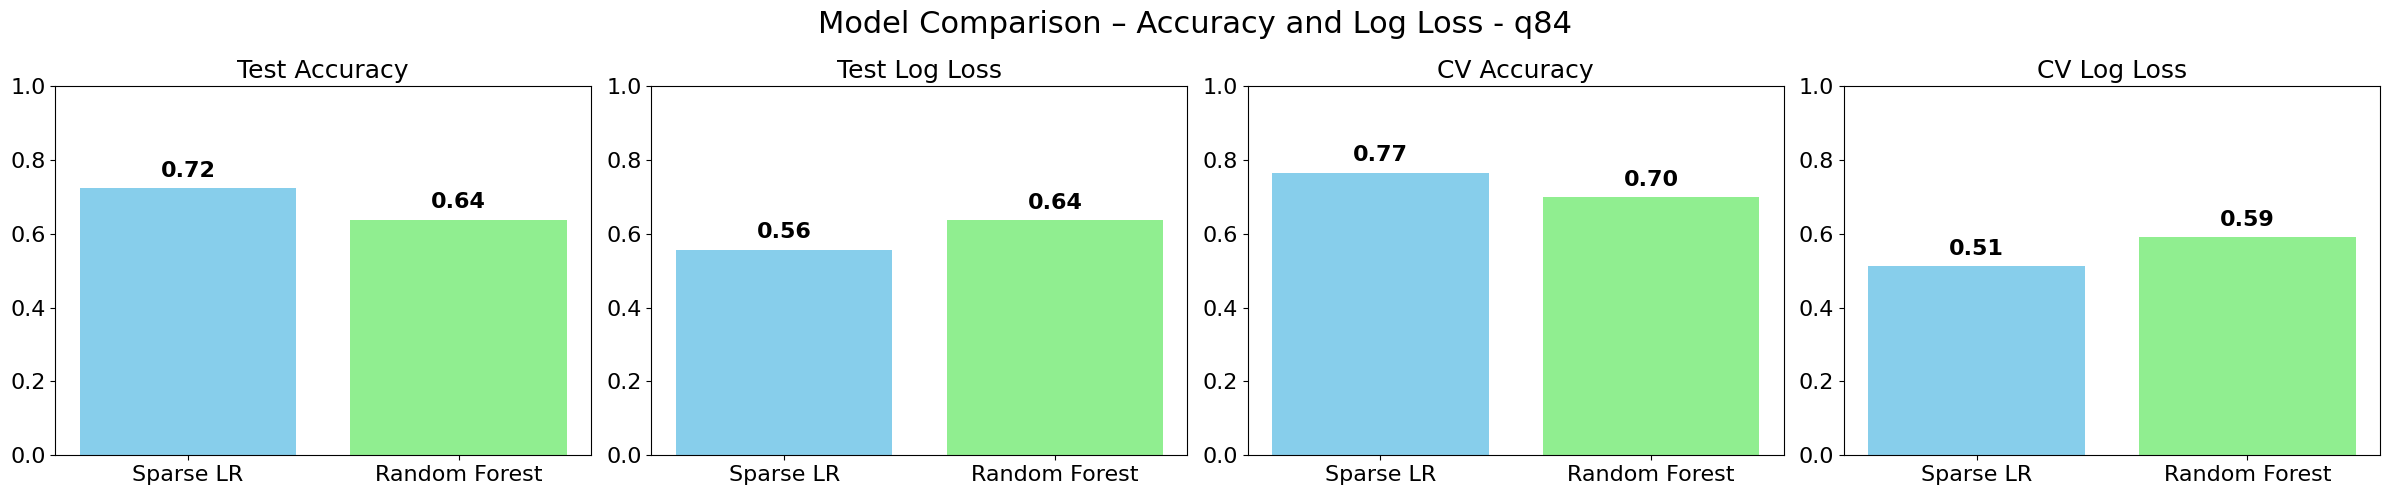

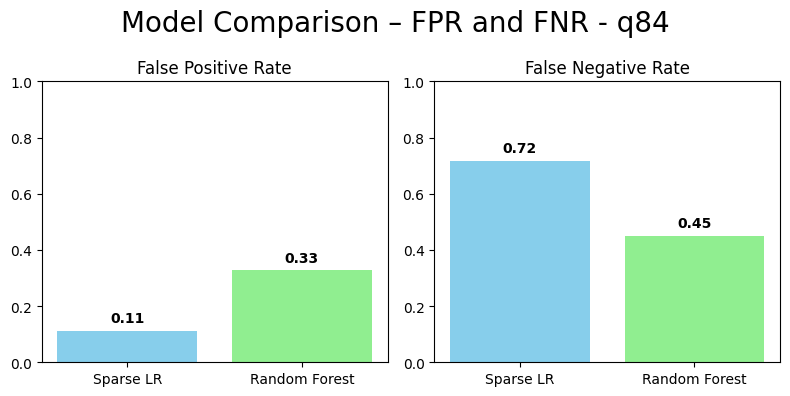

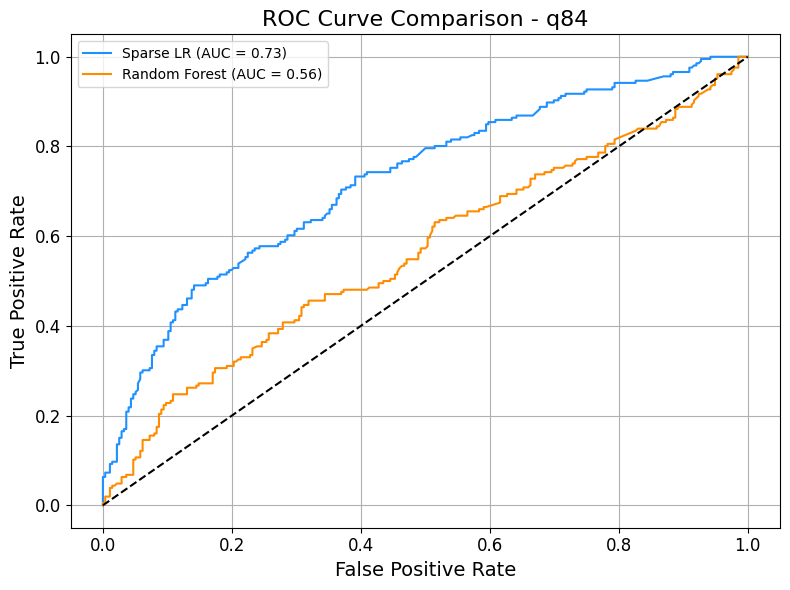

In [ ]:
# ------------ 1. Display Shared Top Features with Labels ------------ #
shared_features = set(top_features_slr['Feature']) & set(top10_rf['Feature'])
labeled_shared = [feature_labels.get(f, f) for f in sorted(shared_features)]
print("Shared Top Features (SLR & RF):")
for name in labeled_shared:
    print("→", name)


# ------------ 2. Compare Metrics (4 in first row, 2 in second) ------------ #

# Replace with your computed values
acc_slr = test_accuracy
acc_rf = test_accuracy_rf

logloss_slr = test_logloss
logloss_rf = test_logloss_rf

fpr_slr = fpr
fpr_rf = fpr_rf

fnr_slr = fnr
fnr_rf = fnr_rf

cv_acc_slr = cv_accuracy_scores.mean()
cv_acc_rf = cv_accuracy_rf.mean()

cv_logloss_slr = cv_logloss_scores.mean()
cv_logloss_rf = cv_logloss_rf.mean()

# Grouped measures
metrics = ['Test Accuracy', 'Test Log Loss', 'CV Accuracy', 'CV Log Loss']
slr_values = [acc_slr, logloss_slr, cv_acc_slr, cv_logloss_slr]
rf_values = [acc_rf, logloss_rf, cv_acc_rf, cv_logloss_rf]

# First row - 4 plots
fig, axes = plt.subplots(1, 4, figsize=(24, 5))
for i, ax in enumerate(axes):
    ax.bar(['Sparse LR', 'Random Forest'], [slr_values[i], rf_values[i]], color=['skyblue', 'lightgreen'])
    ax.set_title(metrics[i], fontsize=18)
    # Tick label font size
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylim(0, 1)
    for j, val in enumerate([slr_values[i], rf_values[i]]):
        ax.text(j, val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=16)
plt.suptitle("Model Comparison – Accuracy and Log Loss - q84", fontsize=22)
plt.tight_layout()
plt.show()

# Second row - 2 plots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fpr_vals = [fpr_slr, fpr_rf]
fnr_vals = [fnr_slr, fnr_rf]
labels = ['False Positive Rate', 'False Negative Rate']
for i, ax in enumerate(axes):
    data = fpr_vals if i == 0 else fnr_vals
    ax.bar(['Sparse LR', 'Random Forest'], data, color=['skyblue', 'lightgreen'])
    ax.set_title(labels[i])
    ax.set_ylim(0, 1)
    for j, val in enumerate(data):
        ax.text(j, val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontweight='bold')
plt.suptitle("Model Comparison – FPR and FNR - q84", fontsize=20)
plt.tight_layout()
plt.show()


# ------------ 3. ROC Curve Comparison ------------ #
fpr_slr_curve, tpr_slr, _ = roc_curve(y26_test, y26_proba)
fpr_rf_curve, tpr_rf, _ = roc_curve(y26_test, y_prob_rf)

auc_slr = auc(fpr_slr_curve, tpr_slr)
auc_rf = auc(fpr_rf_curve, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_slr_curve, tpr_slr, label=f'Sparse LR (AUC = {auc_slr:.2f})', color='dodgerblue')
plt.plot(fpr_rf_curve, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison - q84', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()